# Deep Learning
### Week 5: Convolutional neural networks

## Contents

[1. Introduction](#introduction)

[2. Convolutional neural networks](#convnets)

[3. CNNs and feature maps (\*)](#cnnsfeaturemaps)

[4. Padding and strides](#paddingstrides)

[5. Transposed convolutions](#transposed_convolutions)

[References](#references)

<a class="anchor" id="introduction"></a>
## Introduction

The last week of the module focused on optimisation and regularisation of deep learning models. You learned about several techniques that are essential for successfully training large deep learning models in practice, including optimiser algorithms, weight regularisation, dropout and early stopping. 

You saw how callbacks can be used in TensorFlow to perform actions depending on how the training progresses, such as early stopping or model saving. You also learned how to implement custom callbacks in a model.

This week of the module focuses on another important model architecture. The multilayer perceptron is a general deep learning model architecture, which makes use of several fully connected (dense) layers. However it is often not the optimal choice, and in this week we will see how to build convolutional neural networks (CNNs).

<a class="anchor" id="convnets"></a>
## Convolutional neural networks

A convolutional neural network (CNN) is a type of neural network with a special structure. It can be seen as a special case of the multilayer perceptron architecture that builds certain assumptions into the design of the model, in particular using **local connectivity** and **equivariance**.

An important motivating application for CNNs is **computer vision**, as the architectural design of these networks mimics the visual system, where neurons respond to stimulus in a restricted region of the visual field ([Hubel 1959](#Hubel59)). This concept led initially to the development of the neocognitron ([Fukushima 1980](#Fukushima80)), and later to the modern convolutional neural network trained by backpropagation ([LeCun et al 1989](#LeCun89)). 

In this exposition, we will focus on CNNs for image processing, using 2-D convolutions. However, convolutional neural networks have also been very successful when applied to time series data, using 1-D convolutions. They can also be applied to 3-D image processing tasks, or video analysis, with 3-D convolutions.

#### The convolution operation
The convolution operation for two (Lebesgue integrable) functions $h$ and $k$ is defined as

$$
(h * k)(t) = \int_{-\infty}^\infty h(\tau)k(t - \tau)d\tau.
$$

It can be described as the weighted average of the function $h$ according to the weighting function (or **kernel**) $k$ at each point in time $t$. As $t$ changes, the weighting function emphasises different parts of the input function $h$.

In practice (and in the context of CNNs), we need to discretise the data, and work instead with discrete convolutions:

$$
(h * k)(t) = \sum_{\tau=-\infty}^\infty h(\tau)k(t - \tau).
$$

In this case, we can assume that both $h$ and $k$ (and the convolution $(h * k)$) take integer arguments. In addition, when the kernel function $k$ has finite support, we can write the above as a finite summation.

In convolutional neural networks with image inputs, a 2-D discrete convolution is used:

$$
(\mathbf{h} * \mathbf{k})(i, j) = \sum_{m, n} h(m, n) k(i - m, j - n).
$$

In the above, we will consider $h(i, j)$ and $k(i, j)$ to denote the $(i, j)$-th elements of the matrices $\mathbf{h}\in\mathbb{R}^{n_h\times n_w}$ and $\mathbf{k}\in\mathbb{R}^{k_h\times k_w}$ respectively, where $n_h$ and $n_w$ are the image height and width in pixels, and $k_h$ and $k_w$ are the kernel height and width in pixels. We will use bold lower case for the matrices $\mathbf{h}$ and $\mathbf{k}$ for consistency of notation with previous sections. Typically the ks are less than the ns since kernel is smaller matrix. h would be say an image.

In practice, many libraries implement the **cross-correlation** operation, which is the same as above but changing the orientation of the arguments:

$$
(\mathbf{h} * \mathbf{k})(i, j) = \sum_{m, n} h(i + m, j + n) k(m, n). 
$$

We will refer to the above operation in CNNs as a **convolution**.

As an example, consider a grayscale image $\mathbf{x} =: \mathbf{h}^{(0)}\in\mathbb{R}^{7\times 7}$ with height and width $n_h=n_w=7$, as illustrated in the following figure.

<img src="figures/1_channel_no_padding_crop.png" alt="Input grayscale image" style="width: 550px;"/>
<center>Pixels in a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 7}$</center>

Suppose we define a kernel matrix $\mathbf{k}\in\mathbb{R}^{3\times 4}$. The operation \eqref{crosscorrelation} can be visualised in the following animation, as sweeping the convolutional kernel $\mathbf{k}$ across the input image. At each step, the weights of the kernel matrix $\mathbf{k}\in\mathbb{R}^{3\times 4}$ are multiplied pointwise by the values of the pixels outlined in red and summed together to produce the pre-activation of the neuron in the next hidden layer.

<img src="figures/1_channel_no_padding.gif" alt="2D convolution on a single channel input" style="width: 600px;"/>
<center>2-D convolution with kernel $\mathbf{k}\in\mathbb{R}^{3\times 4}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 7}$</center>

In convolutional neural networks, the convolutional layers usually consist of the operation \eqref{crosscorrelation} plus a bias term, followed by a pointwise activation function:

$$
\mathbf{h}^{(k)} = \sigma\left((\mathbf{h}^{(k-1)} * \mathbf{k}^{(k-1)}) + b^{(k-1)}\right). \tag{2}
$$

In the above, the superscript $(k)$ indexes the layer as before, and the bias $b^{(k-1)}\in\mathbb{R}$ is added pointwise to the output of the convolution operation $(\mathbf{h}^{(k-1)} * \mathbf{k}^{(k-1)})\in\mathbb{R}^{(n_h-k_h+1)\times (n_w-k_w+1)}$.

Different values of the kernel $\mathbf{k}\in\mathbb{R}^{3\times 4}$ will pick out different features in the input $\mathbf{h}^{(k-1)}$. The output of \eqref{convlayer} is sometimes referred to as a **feature map**, and the kernel $\mathbf{k}$ is also referred to as a **filter**.

Note that the operation described above introduces a translational **equivariance** property in convolutional layers. That is, if the input image is translated, then the activations in the next hidden layer are also translated accordingly. Another way to view this is that the convolutional kernel searches for the same features across the input image.

#### Multi-channel inputs and outputs
The operations \eqref{crosscorrelation} and \eqref{convlayer} can easily be extended to inputs with multiple channels. Consider, for example, an input RGB image, which has three channel values per pixel.

<img src="figures/3_channel_no_padding_crop.png" alt="Input RGB image" style="width: 550px;"/>
<center>Pixels in an RGB input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 3}$</center>

The input is now a rank-3 tensor $\mathbf{x} = \mathbf{h}^{(0)}\in\mathbb{R}^{7\times 7\times 3}$, and correspondingly we require a rank-3 kernel tensor $\mathbf{k}\in\mathbb{R}^{k_h\times k_w\times 3}$. For illustration we will again choose $k_h=3$, $k_w=4$. The operation \eqref{crosscorrelation} now becomes

$$
(\mathbf{h} * \mathbf{k})(i, j) = \sum_{m, n, p} h(i + m, j + n, p) k(m, n, p).
$$

This is visualised in the following animation, where the kernel $\mathbf{k}$ again sweeps over the input image, this time multiplying a $3\times 4\times 3$ block of input pixels (outlined in red) elementwise by the values of the kernel tensor $\mathbf{k}$, and summing the results to produce the output neuron pre-activation.

<img src="figures/3_channel_no_padding.gif" alt="2D convolution on a 3-channel (RGB) input" style="width: 550px;"/>
<center>2-D convolution with kernel $\mathbf{k}\in\mathbb{R}^{3\times 4\times 3}$ operating on an RGB input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 3}$</center>

In convolutional layers, many filters are stacked on top of each other, so as to produce a multichannel output. In practice, we implement this with a rank-4 kernel tensor $\mathbf{k}\in\mathbb{R}^{k_h, k_w, c_{in}, c_{out}}$, where $c_{in}$ are the number of channels in the input, and $c_{out}$ are the number of channels in the output: 

$$
(\mathbf{h} * \mathbf{k})(i, j, q) = \sum_{m, n, p} h(i + m, j + n, p) k(m, n, p, q).
$$

This is visualised in the following animation, for an input $\mathbf{x}\in\mathbb{R}^{7\times 7\times 3}$ and kernel tensor $\mathbf{k}\in\mathbb{R}^{3\times 4\times 3\times 2}$.

<img src="figures/3_2_channel_no_padding.gif" alt="2D convolution on an 3-channel (RGB) input with 2 filters" style="width: 550px;"/>
<center>2-D convolution with kernel $\mathbf{k}\in\mathbb{R}^{3\times 4\times 3}$ operating on an RGB input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 3\times 2}$ with 2 filters</center>

The convolutional layer operation \eqref{convlayer} now becomes the following

$$
\mathbf{h}^{(k)} = \sigma\left((\mathbf{h}^{(k-1)} * \mathbf{k}^{(k-1)}) + \mathbf{b}^{(k-1)}\right),\label{convlayer_multichannel}\tag{3}
$$

where again the superscript $(k)$ indexes the layer, and the bias $\mathbf{b}^{(k-1)}\in\mathbb{R}^{c_{out}}$ is added pixel-wise to the output of the convolution operation $(\mathbf{h}^{(k-1)} * \mathbf{k}^{(k-1)})\in\mathbb{R}^{(n_h-k_h+1)\times (n_w-k_w+1)\times c_{out}}$.

#### Pooling layers
In many CNN models, convolutional layers are alternated with pooling layers. Pooling layers downsample the spatial dimensions of a layer by computing a summary statistic of (often non-overlapping) regions of the input layer's post-activations.

A typical pooling layer type is the **max pooling** layer ([Zhou & Chellappa 1988](#Zhou88)) which takes the maximum activation in a region as the single neuron activation for that region. For example, we could divide the input layer into $2\times2$ squares and take the maximum value for each square. This results in halving the spatial dimensions of the following layer.

<img src="figures/max_pooling.png" alt="Max pooling" style="width: 550px;"/>
<center>Max pooling using $2\times2$ pooling windows</center>

Pooling operations are usually performed separately for each input channel, so that the spatial dimensions are downsampled, but the channel dimensions stay the same. Other common pooling operations include average pooling, or computing the $\mathcal{l}^2$ norm of the pixel values within each input region.

<a class="anchor" id="cnnsfeaturemaps"></a>
## CNNs and feature maps

In this section we will use the `Conv2D` and `MaxPool2D` layer to implement the convolution and pooling operations described above, and see how these easily fits into our existing model-building workflow.

We will also see the effect of different kernel tensor choices on the output feature maps, and look at more complex feature maps from a pre-trained model.

In [1]:
import tensorflow as tf

The `Conv2D` and `MaxPool2D` classes are imported from the `tf.keras.layers` module just as the `Flatten` and `Dense` layers we have already worked with. Note that there are also 1-D and 3-D variants of these layers available, which both work in a similar way.

In [5]:
# Define a dummy model with Conv2D and MaxPool2D layers

from keras import Sequential
from keras.layers import Conv2D, MaxPool2D

model = Sequential([
    #8 filters, 3 height, 5 width
    #input is 32x32x3 colours
    Conv2D(8,(3,5),activation = "relu", input_shape = (32,32,3)),
    #(2,2) is the default window size for pooling
    MaxPool2D((2,2)),
    #3 by itself means (3,3)
    Conv2D(16,3,activation = "relu"),
    #same as above
    MaxPool2D(2)
])

In [7]:
# Print the model summary

model.summary()
#output shape in first layer is smaller in width, since kernel layer window had bigger width
#8 is number of channels output (like neurons. which is why bias has same size, added pixel wise (broadcasted))

#max pooling halves dimensions, leaving channels

#then we take it to 16 channels

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 28, 8)         368       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 12, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
Total params: 1,536
Trainable params: 1,536
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Inspect the layer variables' shapes
print(model.layers[0].kernel.shape)
#height, width, cin, cout
print(model.layers[0].bias.shape)

print(model.layers[2].kernel.shape)
#height, width, cin, cout
print(model.layers[2].bias.shape)

#bias same dim as number of filters

(3, 5, 3, 8)
(8,)
(3, 3, 8, 16)
(16,)


In [20]:
a = tf.constant([[[[1,2,3,4,5,6,7,8,9,0],[1,2,3,4,5,6,7,8,9,0]]]])
print(a.shape)
b = tf.constant([1,2,3,4,5,6,7,8,9,0])
a+b

(1, 1, 2, 10)


<tf.Tensor: shape=(1, 1, 2, 10), dtype=int32, numpy=
array([[[[ 2,  4,  6,  8, 10, 12, 14, 16, 18,  0],
         [ 2,  4,  6,  8, 10, 12, 14, 16, 18,  0]]]])>

#### Edge detection filters
The kernels (or filters) in CNNs are typically learned with backpropagation. However, simple low-level features such as edge detection kernels can also be designed by hand. In this section we will see the output of such low-level kernels.

In [22]:
# Define a simple model with a Conv2D layer

model = Sequential([
    #specifying none is fine in convolutional layers since the kernel can sweep over input of any size
    #bigger input means bigger output
    Conv2D(1, (3, 3), activation=None, use_bias=False, input_shape=(None, None, 1))
])

A shape dimension of `None` indicates that the model can take flexible input sizes in this dimension.

In [24]:
# Inspect the model's weights

model.weights
#kernek height and width 3, input and output channels both 1

[<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 1, 1) dtype=float32, numpy=
 array([[[[ 0.32106757]],
 
         [[-0.02402192]],
 
         [[ 0.15893847]]],
 
 
        [[[-0.45544252]],
 
         [[-0.07872579]],
 
         [[ 0.27599263]]],
 
 
        [[[ 0.03811282]],
 
         [[-0.09984255]],
 
         [[ 0.3754567 ]]]], dtype=float32)>]

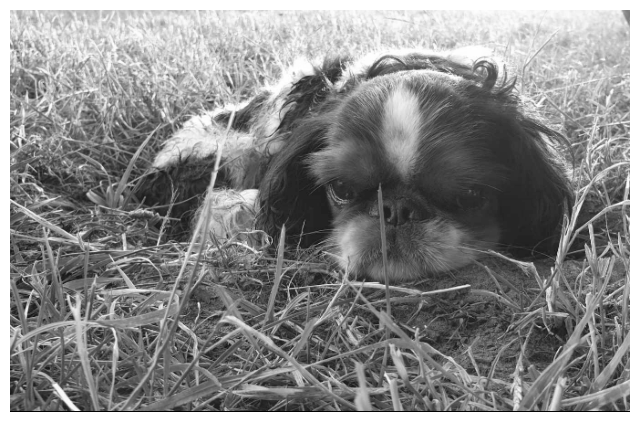

(441, 680, 1)


In [29]:
# Load an image as grayscale

import matplotlib.pyplot as plt

image = tf.io.read_file("./figures/oscar.png")
#convert
image = tf.io.decode_png(image, channels=1)
plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print(image.shape)

A simple and intuitive edge detection kernel is the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator):

In [26]:
# Define simple edge detection filters

sobel_x = tf.constant([[1, 0, -1], [2, 0, -2], [1, 0, -1]], dtype=tf.float32)
sobel_y = tf.constant([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=tf.float32)

print(sobel_x)
print(sobel_y)

#these filters output 0 when nothing happens across the x and y direction respectively
#then the large positive and negative values come from when there are big changes eg black to white in x or y direction respectively

tf.Tensor(
[[ 1.  0. -1.]
 [ 2.  0. -2.]
 [ 1.  0. -1.]], shape=(3, 3), dtype=float32)
tf.Tensor(
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]], shape=(3, 3), dtype=float32)


In [27]:
# Set the model kernel

def assign_filter(arr):
    #could habe done with tf.expand_dims
    model.weights[0].assign(arr[:, :, tf.newaxis, tf.newaxis])

In [49]:
# Compute the feature maps

assign_filter(sobel_x)
#cant do model(image) since layers always expect the first dimnsion to be batch
print(image[None,:].shape)
#we get rid of the batch by getting the 0th element
gx = model(image[None, ...])[0]
print(gx.shape)

assign_filter(sobel_y)
gy = model(image[None, ...])[0]
print(gy.shape)
#total gradient magnitude
g = tf.sqrt(tf.square(gx) + tf.square(gy))
print(g.shape)

(1, 441, 680, 1)
(439, 678, 1)
(439, 678, 1)
(439, 678, 1)


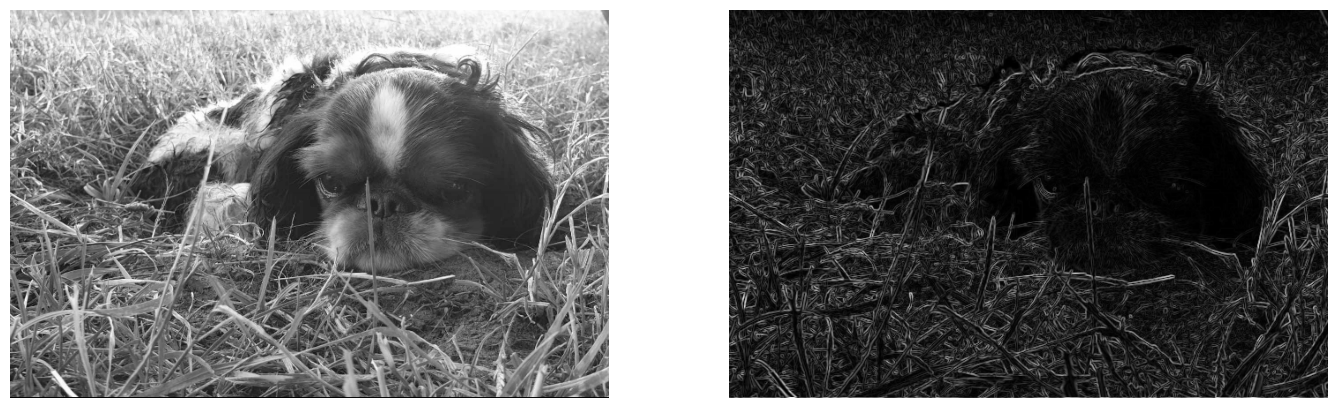

In [47]:
# View the image and feature map

fig = plt.figure(figsize=(17, 6))
fig.add_subplot(121)
plt.imshow(image, cmap='gray')
plt.axis('off')
fig.add_subplot(122)
#x edges, change gx to gy and g
plt.imshow(g, cmap='gray')
plt.axis('off')
plt.show()

#### Extract learned features from a pre-trained model
In this section we will load a CNN model that has been pre-trained on the [ImageNet](http://www.image-net.org) dataset, which is a large scale image classification dataset which to date has over 20,000 categories and over 14 million images. Large deep learning models trained on this dataset tend to learn general, useful representations of image features that can be used for a range of image processing tasks.

Below we will load the VGG-19 model ([Simonyan & Zisserman 2015](#Simonyan15)), which is available to load as a pre-trained model in the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module. This might take a minute or two to download the first time you run the cell.

In [53]:
# Load the VGG-19 model

vgg = tf.keras.applications.VGG19(weights='imagenet') 
#this version has a specific input shape since we have a dense and flatten layer
#most of the params are at the end in the dense layers, since CNNs use weight sharing across multiple filters



#can pass include_top = False, then the final flatten and dense layers wont be included at the end,
#which means the model will accept any height and width sized images (first one is always None)
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False) 

#we also lose most of the parameters, since they were in the dense layers, as they dont weight share
#the fact we have the flatten and dense layers mean we need them to know the input sizes, hence
#we have to force it at the start when we have include_top = True

In [54]:
# Print the model summary

vgg.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

We will visualise the features extracted by this model at different levels of hierarchy for the following image:

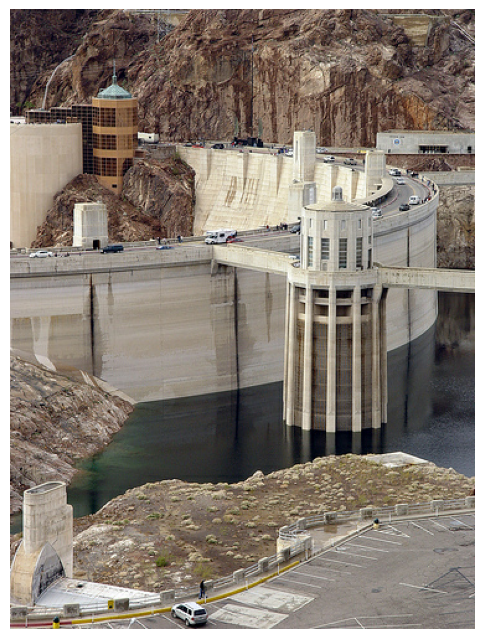

In [55]:
# Load a colour image

image = tf.io.read_file("./figures/hoover_dam.JPEG")
#again convert
image = tf.io.decode_jpeg(image, channels=3)
plt.figure(figsize=(6, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

We will use the [functional API](https://www.tensorflow.org/guide/keras/functional) to create a multi-output model that outputs different hidden layer outputs within the model.

In [57]:
# Define the multi-output model

from keras.models import Model

#inputs are same as vgg
inputs = vgg.inputs
#define the outputs from the cnn layers, can do so through indexing or names
#goes from shallow to deep in the model
layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv4', 'block4_conv4', 'block5_conv4']
outputs = [vgg.get_layer(layer_name).output for layer_name in layer_names]
vgg_features = Model(inputs=inputs, outputs=outputs)

In [62]:
# View the model inputs and outputs Tensors

#same tensor as that to vgg model
vgg_features.input
vgg.input

vgg_features.outputs

[<KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float32 (created by layer 'block3_conv4')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block4_conv4')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float32 (created by layer 'block5_conv4')>]

In [77]:
# Extract the hierarchical features for this image

#the vgg model was trained on preprocessed images, this function can be obtained:

image_processed = tf.keras.applications.vgg19.preprocess_input(image)

#these do the same
print(image_processed[None,:].shape)
print(image_processed[tf.newaxis,:].shape)

#need batch dimension of course
features = vgg_features(image_processed[tf.newaxis, ...])
features = [image] + features
#we add the original image tensor for comparison
#have to put image in array since features is like that


(1, 500, 375, 3)
(1, 500, 375, 3)


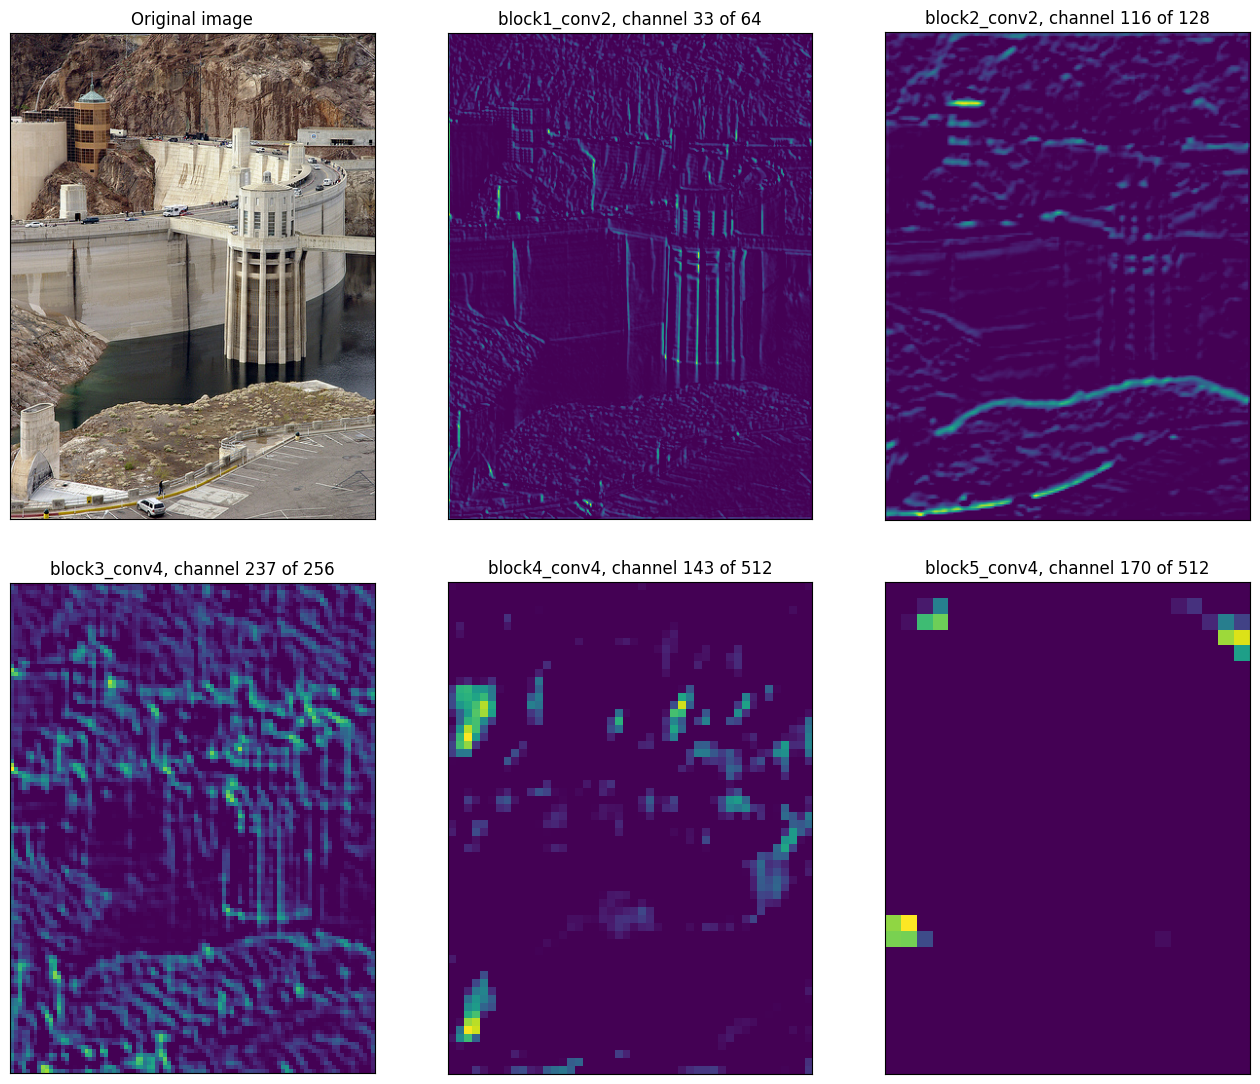

In [85]:
# Visualise the features

import numpy as np


#randomly samples one of the feature maps from each of the output tensors in our model

n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features)):
    feature_map = features[i]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[row, col].imshow(image)
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

#feature maps in lower levels are looking at lower level features, like edge detection
#deeper in the model, image size decreases and each feature map sees more of og image in each location
#picking out increasingly more complex parts of the image, combining the previous layers.
#these are higher level properties at the end, that get closer to the image label

*Exercise:* load one of your own images to view the features extracted by the VGG-19 network.

<a class="anchor" id="paddingstrides"></a>
## Padding and strides

Padding and strides are additional properties of convolutional (and pooling) layers that can give some flexibility over the spatial dimensions of the output. 

In this section, we will define these properties and the effects they have on the input and output dimensions of a convolutional layer. For a more complete guide to convolutional arithmetic, see [Dumoulin & Visin 2016](#Dumoulin16).

In [ ]:
import tensorflow as tf

#### Padding
Recall that in our earlier example, an input grayscale image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 1}$ convolved with a kernel $\mathbf{k}\in\mathbb{R}^{3\times 4\times 1\times 1}$ produced an output of size $\mathbf{h}\in\mathbb{R}^{5\times 4\times 1}$:

<img src="figures/1_channel_no_padding.gif" alt="2D convolution on a single channel input" style="width: 600px;"/>
<center>
A kernel $\mathbf{k}\in\mathbb{R}^{3\times 4\times1\times1}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 1}$ produces an output $\mathbf{h}\in\mathbb{R}^{5\times 4\times 1}$
</center>

In general, for a spatial dimension of size $i$ and a kernel of width $k$, the output size $o$ is given by

$$
o = i - k + 1 \tag{4}
$$

In many model architectures, it is desirable to keep the spatial dimensions the same in the output of a convolutional layer. This can be achieved by padding the input layer with zeros.

In the case of our kernel tensor $\mathbf{k}\in\mathbb{R}^{3\times 4\times1\times1}$, if we add 2 zeros in the first dimension and 3 zeros in the second dimension (distributed on either side of the image), this will result in an output $\mathbf{h}\in\mathbb{R}^{7\times 7\times 1}$ that has the same spatial dimensions as the input $\mathbf{x}$. This type of padding is known as "SAME" padding.

<img src="figures/1_channel_with_padding.gif" alt="2D convolution on a single channel input with 'SAME' padding" style="width: 600px;"/>
<center>A kernel $\mathbf{k}\in\mathbb{R}^{3\times 4\times1\times1}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 1}$ with "SAME" padding</center>

Now, if $p$ zeros are added to our input size $i$ with kernel width $k$, then the output size $o$ is given by

$$
o = i + p - k + 1 \tag{5}
$$

If $p = k-1$ ("SAME" padding) then the $o = i$. If $p = 0$ ("VALID" padding) then we recover \eqref{valid} and $o = i-k+1$. There is also "FULL" padding where $p = 2(k-1)$, so that $o = i + k - 1$, although this is less common.

In TensorFlow, we can easily apply zero padding to convolutional layers with the `padding` keyword argument, which can be set to `"VALID"` (the default) or `"SAME"`.

In [ ]:
# Create a CNN with 'VALID' and 'SAME' padding

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D

inputs = Input(shape=(32, 32, 3))
h = Conv2D(16, (3, 5), padding="VALID", activation='relu')(inputs)
h = MaxPool2D(2)(h)
outputs = Conv2D(16, 3, padding="SAME", activation='relu')(h)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Note the input and output shapes of each of the convolutional layers.

#### Strides
Convolutions may also use a stride $s$, which is the distance between consecutive positions of the kernel. So far, all of our examples have used $s=1$, however it is easy to see that using $s>1$ leads to a downsampling of the input. The following animation shows our input $\mathbf{x}\in\mathbb{R}^{7\times7\times 1}$, this time with a kernel $\mathbf{k}\in\mathbb{R}^{3\times 3\times1\times1}$, "SAME" padding, and a stride $s=2$ in both spatial dimensions:

<img src="figures/1_channel_stride_2.gif" alt="2D convolution on a single channel input with stride 2" style="width: 600px;"/>
<center>A kernel $\mathbf{k}\in\mathbb{R}^{3\times 3\times1\times1}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 7\times 1}$ with "SAME" padding and stride of $(2, 2)$</center>

In the above example, the stride and kernel size exactly divides the input and padding size, however this does not need to be the case, such as in the following example where $\mathbf{x}\in\mathbb{R}^{7\times6\times 1}$:

<img src="figures/1_channel_7x6_stride_2.gif" alt="2D convolution on a single channel input with stride 2" style="width: 600px;"/>
<center>A kernel $\mathbf{k}\in\mathbb{R}^{3\times 3\times1\times1}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 6\times 1}$ with "SAME" padding and stride of $(2, 2)$</center>

In this example the input $\mathbf{x}\in\mathbb{R}^{7\times6\times 1}$ has been downsampled to an output $\mathbf{h}\in\mathbb{R}^{4\times 3\times 1}$. Note that if the input image size was instead $7\times 5\times 1$ then the output size would again be $4\times 3\times 1$.

<img src="figures/1_channel_7x5_stride_2.gif" alt="2D convolution on a single channel input with stride 2" style="width: 600px;"/>
<center>A kernel $\mathbf{k}\in\mathbb{R}^{3\times 3\times1\times1}$ operating on a grayscale input image $\mathbf{x}\in\mathbb{R}^{7\times 5\times 1}$ with "SAME" padding and stride of $(2, 2)$</center>

In all cases, for a spatial dimension of size $i$ with padding $p$ and a kernel of width $k$ with stride $s$, the output size $o$ is given by

$$
o = \left\lfloor \frac{i + p - k}{s} \right\rfloor + 1 \label{stride}\tag{6}
$$

In TensorFlow, strides can be set in both convolutional and pooling layers using the `strides` keyword argument. 

Just as with the `kernel_size` argument for `Conv2D` layers (and the `pool_size` argument for `MaxPool2D` layers), either a tuple of integers can be passed in, or a single integer - which indicates the stride should be the same in all spatial dimensions. 

In `MaxPool2D` layers, the default stride is set to be equal to the `pool_size`.

In [ ]:
# Create a CNN using strides in the Conv2D and MaxPool2D layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense

inputs = Input(shape=(128, 128, 3))
h = Conv2D(16, (5, 5), padding="VALID", strides=(2, 3), activation='relu')(inputs)
h = MaxPool2D(2)(h)
h = Conv2D(16, 7, padding="SAME", activation='relu')(h)
h = MaxPool2D((2, 4), strides=(3, 2))(h)
h = Conv2D(16, 3, padding="SAME", strides=2, activation='relu')(h)
h = Flatten()(h)
h = Dense(16, activation='relu')(h)
outputs = Dense(1, activation='sigmoid')(h)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Note the input and output shapes of each of each layers, and compare with the formula $(6)$ for the output size given above.

<a class="anchor" id="transposed_convolutions"></a>
## Transposed convolutions

Transposed convolutions are a type of convolutional layer that are not as common as the convolutional and pooling layers introduced earlier, but are important for certain applications. They can be seen as a kind of inverse of regular convolutional layers. The main problem they are trying to solve is to give a consistent way of upsampling an input, rather than downsampling it. 

We've seen that in convolutional layers and in pooling layers, depending on the layer settings, they can reduce the spatial dimensions of the input. In certain deep learning architectures, we would instead like to increase the spatial dimensions of an input. An example of this is when we are using encoder and decoder networks, which we will come to later on in the course. 

Transposed convolutions give us a way of doing this, while still preserving the main structural properties of convolutional layers. They are the analogue to transposing the weight matrix in fully connected layers; they essentially swap the forward and backward passes of a convolution. Here we will briefly cover the core properties of the transposed convolution. For a more detailed treatment, see [Dumoulin & Visin 2016](#Dumoulin16).

Every regular convolutional layer has an associated transposed convolution that reverses the dimensions of input and output, whilst preserving the connectivity pattern between the layers. This transposed convolution can always be interpreted as a regular convolution, with particular kernel size, padding and stride parameters.

In the case of a convolution with stride $s=1$, kernel size $k$, padding $p$ and input size $i$, recall the output size is $o = i + p - k +1$. There is an associated transposed convolution with kernel size $k' = k$, stride $s'=s=1$, and padding $p'=2(k-1) - p$ . Its output size is given by

$$
o' = i' + (k-1) - p,
$$

so with $i' = o$, we have $o' = i$, and the transposed convolution reverses the input and output dimensions.

The following animations show an example of a $3\times 3$ convolution applied to an input $\mathbf{x}\in\mathbb{R}^{5\times 5}$, with a stride of $1$ and no padding. The associated transposed convolution has an input $\mathbf{y}\in\mathbb{R}^{3\times 3}$, stride of one and padding of two zeros on either side of the input ("FULL" padding).

<table><tr>
<td> <img src="figures/3x3conv.gif" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="figures/3x3convt.gif" alt="Drawing" style="width: 448px;"/> </td>
</tr></table>
<center>A regular convolution (left) and its associated transposed convolution (right). The input and output dimensions are reversed, but the connectivity pattern between neurons remains the same</center>

In TensorFlow, the transposed convolution is available as the `Conv2DTranspose` layer (also 1D and 3D variants).

In [ ]:
# Create a transposed convolution layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2DTranspose

cnn = Sequential([
    Conv2DTranspose(1, (3, 3), input_shape=(3, 3, 1), padding="VALID")
])
cnn.summary()

For a regular convolution with stride $s>1$, we can think of the associated transposed convolution as having a stride $s'<1$ (another name for transposed convolutions is **fractionally strided convolutions**). In this case, the situation is more complicated. This is because for $s>1$, different sized inputs can lead to the same size output. 

Consider first the case where the regular convolution is such that $s$ divides $(i + p -k)$. Recall that the output size is then $o = \left(\frac{i + p -k}{s}\right) + 1$. Then, the input to the associated transposed convolution adds $s-1$ zeros between its input units. It has kernel size $k'=k$, $s'=1$, and padding $p'=2(k-1) - p$. The output size is given by

$$
o' = s(i' - 1) + k - p.
$$

The following shows an example. An input $\mathbf{x}\in\mathbb{R}^{3\times 3}$ is processed by a convolution with a $3\times 3$ kernel, stride $s=2$ and padding $p=2$ ("SAME" padding). Its output size is $2\times 2$. The associated transposed convolution takes an input $\mathbf{y}\in\mathbb{R}^{2\times 2}$, inserts one zero in between the input units and padding $p'=2$.

<table><tr>
<td> <img src="figures/3x3convs2.gif" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="figures/3x3convs2t.gif" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>
<center>A regular convolution with stride $s=2$ (left) and its associated transposed convolution (right). Note that $s \mid (i + p - k)$. The transposed convolution inserts one zero in between each input unit</center>

In [ ]:
# Create a transposed convolution layer with fractional stride

cnn = Sequential([
    Conv2DTranspose(1, (3, 3), strides=2, input_shape=(2, 2, 1), padding="SAME", output_padding=0)
])
cnn.summary()

The case where $s$ does not divide $(i + p - k)$ is accounted for by the parameter $a = (i + p - k)\mod s$. The transposed convolution again adds $s-1$ zeros between input units, but also adds additional padding of $a$ zeros, which then increases the dimension of its output. It has kernel size $k'=k$, $s'=1$, padding $p'=2(k-1) - p + a$, and output size

$$
o' = s(i' - 1) + a + k - p
$$

The following shows hows the same output size as the previous example can be produced by the same convolution operation, for a different input size. The input is now $\mathbf{x}\in\mathbb{R}^{4\times 4}$, with a $3\times 3$ kernel, stride $s=2$ and padding $p=2$ as before. The associated transposed convolution again takes an input $\mathbf{y}\in\mathbb{R}^{2\times 2}$, but this time produces an output with spatial dimensions $4\times 4$.

<table><tr>
<td> <img src="figures/3x3convs2b.gif" alt="Drawing" style="width: 367px;"/> </td>
<td> <img src="figures/3x3convs2bt.gif" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>
<center>A regular convolution with stride $s=2$ where $s\nmid (i + p - k)$ (left) and its associated transposed convolution (right). An additional $a = (i + p + k)\text{ mod } s = 1$ zero is added to the input of the transposed convolution</center>

In [ ]:
# Create a transposed convolution layer with fractional stride and additional output padding

cnn = Sequential([
    Conv2DTranspose(1, (3, 3), strides=2, input_shape=(2, 2, 1), padding="SAME", output_padding=1)
])
cnn.summary()

<a class="anchor" id="references"></a>
## References

<a class="anchor" id="Dumoulin16"></a>
* Dumoulin, V. & Visin, F. (2016), "A guide to convolution arithmetic for deep learning", arXiv preprint, abs/1603.07285.
<a class="anchor" id="Fukushima80"></a>
* Fukushima, K. (1980), "Neocognitron: A Self-organizing Neural Network Model for a Mechanism of Pattern Recognition Unaffected by Shift in Position", *Biological Cybernetics*, **3**6 (4), 193–202.
<a class="anchor" id="Hubel59"></a>
* Hubel, D. H. & Wiesel, T. N. (1959), "Receptive fields of single neurones in the cat's striate cortex", *Journal of Physiology* **148** (3), 574–91.
<a class="anchor" id="LeCun89"></a>
* LeCun, Y., Boser, B., Denker, J. S., Henderson, D., Howard, R. E., Hubbard, W., & Jackel, L. D. (1989) "Backpropagation Applied to Handwritten Zip Code Recognition", AT&T Bell Laboratories.
<a class="anchor" id="Rumelhart86b"></a>
* Rumelhart, D. E., Hinton, G., and Williams, R. (1986b), "Learning representations by back-propagating errors", Nature, **323**, 533-536.
<a class="anchor" id="Simonyan15"></a>
* Simonyan, K. & Zisserman, A. (2015), "Very Deep Convolutional Networks for Large-Scale Image Recognition", in *3rd International Conference on Learning Representations, (ICLR) 2015*, San Diego, CA, USA.
<a class="anchor" id="Vinyals19"></a>
* Vinyals, O., Babuschkin, I., Czarnecki, W. M., Mathieu, M., Dudzik, A., Chung, J., Choi, D. H., Powell, R., Ewalds, T., Georgiev, P., Oh, J., Horgan, D., Kroiss, M., Danihelka, I., Huang, A., Sifre, L., Cai, T., Agapiou, J. P., Jaderberg, M., Vezhnevets, A. S., Leblond, R., Pohlen, T., Dalibard, V., Budden, D., Sulsky, Y., Molloy, J., Paine, T. L., Gulcehre, C., Wang, Z., Pfaff, T., Wu, Y., Ring, R., Yogatama, D., Wünsch, D., McKinney, K., Smith, O., Schaul, T., Lillicrap, T., Kavukcuoglu, K., Hassabis, D., Apps, C., & Silver, D.(2019) "Grandmaster level in StarCraft II using multi-agent reinforcement learning", *Nature*, **575** (7782), 350-354.
<a class="anchor" id="Zhou88"></a>
* Zhou, Y. & Chellappa, R. (1988), "Computation of optical flow using a neural network", in *IEEE International Conference on Neural Networks*, IEEE, 71-78.